In [74]:
import sys
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

In [75]:
import pandas as pd 
data_air = pd.read_csv("data.txt") 


## generation of vector for plotting samples under histograms
deaths=[]
dta_cnt=[]
for k in data_air['Passenger deaths']:  
    dta_cnt.append(-(1.+deaths.count(k)))
    deaths.append(k)
dta_cnt=np.array(dta_cnt)

data_air

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0
5,1981,21,362,0.06,6033.0
6,1982,26,764,0.13,5877.0
7,1983,20,809,0.13,6223.0
8,1984,16,223,0.03,7433.0
9,1985,22,1066,0.15,7107.0


## Task1. Constant rate for all years and not depending on anything
We define model, assuming, that passengers deaths number $y_i$ has a Poisson distribution$$y_i\sim\mathrm{Poisson}(\lambda)$$with a rate $\lambda$ independent on anything.

## Prior for number of deaths
We assume that 10 people dying in airplane crash every day, which is 10*365=3650 per year would be very improbable. For poisson distribution we have mean of $\lambda$ and standard deviation of $\sqrt{\lambda}$. Approximately in order to have no more than 1% probability $\lambda$ should fulfill$$\lambda+3\sqrt{\lambda}\approx3650$$We need to assign the prior that would have probability of smaller $\lambda$ equal 99%.

In [76]:
root_of_lam=np.polynomial.polynomial.polyroots([-3650.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[3473.]


From calculations we have output $\lambda$ = 3473

## Prior tuning in Stan
Using Stan algebra solver we can solve nonlinear equations. In particular it can be used for finding distribution parameters that are fulfilling the conditions we have given. We can for example find $\sigma$ for a HalfNormal distribution.

In [77]:
with open('prior.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}


In [78]:
m_prior =stan_utility.compile_model('prior.stan')

Using cached StanModel


In [79]:
data=dict(y_guess=np.array([np.log(1000)]),theta=np.array(lam_ub))
tuned2 = m_prior.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned2.extract()['sigma'][0])
print(sigma)

1348.0


## Half- normal distribution
For above value of sigma=1348 we will plot half-normal distribution

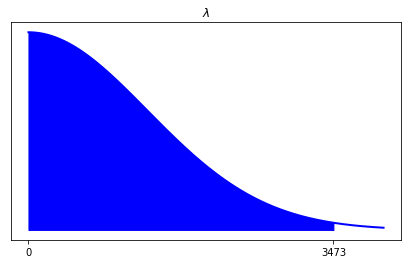

In [52]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color='blue',linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color='blue')
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

## Prior predictive distribution
We can use stan to simulate possible outputs and parameteres based only on prior information.

In [53]:
with open('prior_ppc.stan', 'r') as file:
    print(file.read())


data {
  int M;//number of years analyzed
}


generated quantities {
  real lambda=fabs(normal_rng(0,1348));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [54]:
m_prior=stan_utility.compile_model('prior_ppc.stan')

Using cached StanModel


In [55]:
R=1000
sim_uf=m_prior.sampling(data={'M':1},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

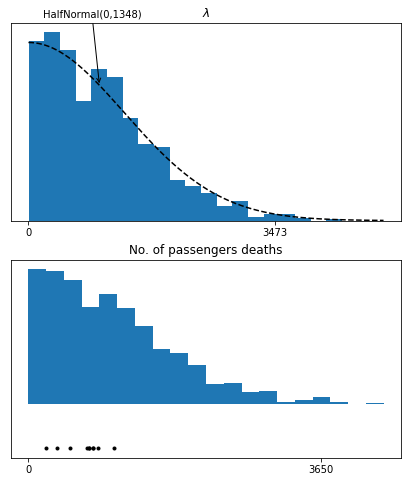

In [70]:
params=sim_uf.extract()
theta=params['lambda']
y_sim=params['y_sim']


fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,5000,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(1000,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(1000,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),density=True,bins=20,zorder=1)
ax2.scatter(deaths,0.0002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,3650])
ax2.set_yticks([])

ax2.set_title('No. of passengers deaths')
plt.show()

## Posterior inference and posterior predictive checks

In [72]:
with open('post.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  int y[M];//number of passengers deaths
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,1348);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [73]:
m_post=stan_utility.compile_model('post.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c91c65bf866794d4ed9a2502f37bf8d7 NOW.


In [81]:
data = dict(M = len(data_air),
            y = data_air['Passenger deaths'])
fit = m_post.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [82]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

In [83]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 691.51
89% confidence interval: [ 678.36 704.75 ]


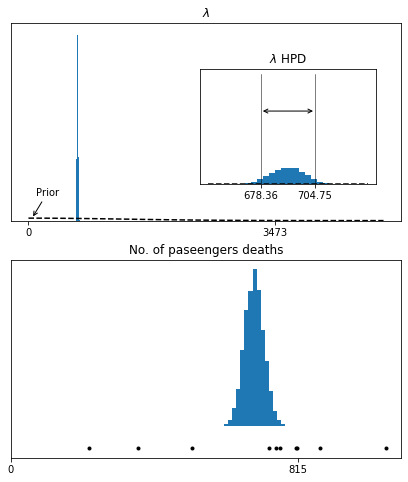

In [99]:
fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lam,bins=20,density=True)
x=np.linspace(0,5000,100)

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(50,0,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2=axes[1]
ax2.hist(y_sim.flatten(),density=True,bins=20,zorder=1)
ax2.scatter(deaths,0.002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of paseengers deaths')
plt.show()

## Using model for prediction
In 1986, there were 546 passenger deaths. We will see how our model predict this number.
In order to predict value in 1986 we just need to use the prior predictive distribution of y_sim.

In [105]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.95)

print('Median of predicted passengers deaths =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted passengers deaths = 691.0
Confidence interval = [ 639.0 746.0 ]


As we can see, number of predicted deaths is quite near the historical value, so our model is properly constructed.

## Task2. Constant intensity, but rate is a product of intensity and miles flown.

In Poisson model we decompose rate $\lambda$ into intensity $\theta$ and exposure $n$, i.e.

$$y_i\sim\mathrm{Poisson}(\theta n)$$
With $n$ being a number miles flown (in 100 mil) .

## Prior for passengers deaths intensity.
We still assume that having 10 deaths every day would be very improbable. Our previous argument, can be still valid, however in order to compute the bound we will use $\lambda=\theta\cdot\bar{n}$, with $\bar{n}$ being mean of miles flown. This gives us condition

$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx3650$$
We need to assign the prior for $\theta$ that would have probability of smaller $\lambda$ equal 99%.

In [108]:
mean_miles=np.mean(data_air['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-3650/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

theta upper bound 0.608


In [111]:
data=dict(y_guess=np.array([np.log(0.1)]),theta=np.array(theta_ub))
tuned2 = m_prior.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned2.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))

sigma = 0.236


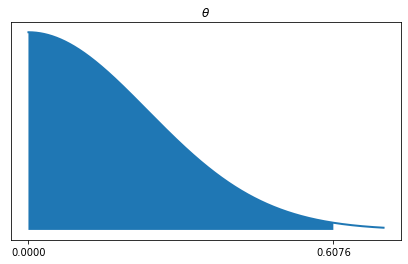

In [116]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_title(r'$\theta$')
plt.show()

## Prior predictive distribution
We can use stan to simulate possible outputs and parameteres based only on prior information.

In [117]:
with open('prior_miles.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
}


generated quantities {
  real theta=fabs(normal_rng(0,0.236));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}


In [118]:
model_prior=stan_utility.compile_model('prior_miles.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a0521f023350c8d175627319c1d89ec7 NOW.


In [119]:
R=1000
data_prior=dict(M=len(data_air),miles=data_air['Miles flown [100 mln miles]'].to_numpy())
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,seed=29042020)

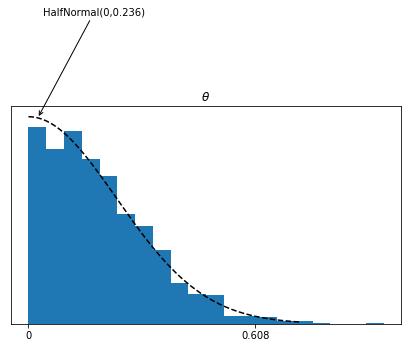

In [121]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.025,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(0.025,arr_y_loc),xytext=(0.04,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

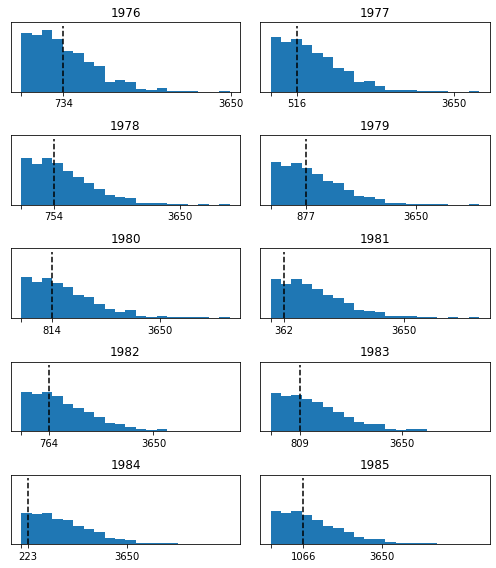

In [134]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,density=True)
    ax.set_title(data_air['Year'][k])
    tv=data_air['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.0009],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,3650])
    ax.set_xticklabels(['',tv,3650])

fig.tight_layout()

plt.show()

## Posterior inference and posterior predictive checks

In [135]:
with open('post_miles.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of passengers deaths
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.021);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}


In [136]:
model_miles=stan_utility.compile_model('post_miles.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_79053f8b4c03ba71494d47929647c0e3 NOW.


In [139]:
data = dict(M = len(data_air),
            miles = data_air['Miles flown [100 mln miles]'],
            y = data_air['Passenger deaths'])
fit = model_miles.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']

In [142]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.95)
hpd_width=cinf_theta[1]-cinf_theta[0]

In [143]:
print('Mean theta : {:5.4f}'.format(mean_theta))
print('95% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1205
95% confidence interval: [ 0.1178 0.1233 ]


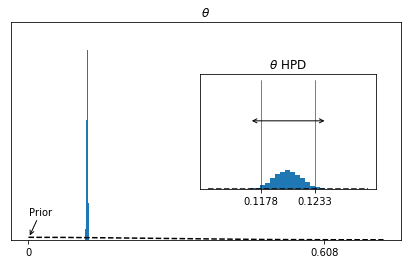

In [149]:
fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1.2*theta_ub[0],5000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.001,0,sigma)
ax1.annotate('Prior',xy=(0.001,arr_y_loc),xytext=(0.0015,10*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(0.99*cinf_theta[0],1000), xytext=(1.01*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

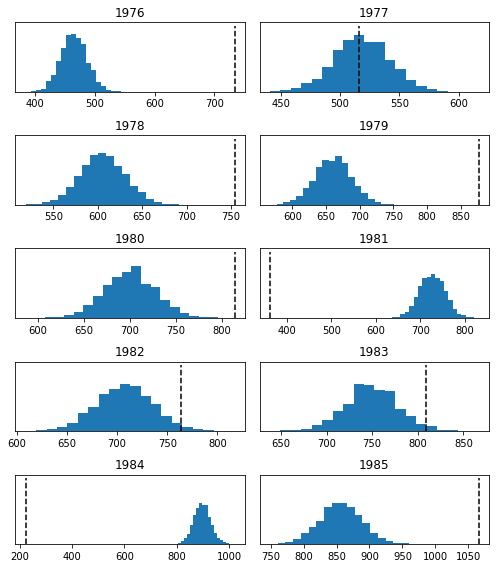

In [162]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,density=True)
    ax.set_title(data_air['Year'][k])
    tv=data_air['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])

fig.tight_layout()

plt.show()

## Using model for prediction
In this situation prediction might be a slight more complicated, as it requires from us modifying the generated quantities block. In 1986, there were 546 passenger deaths, and a death rate of 0.06 per 100 million miles flown.

In [163]:
miles1986=546/0.06
print(np.round(miles1986))

9100.0


In [164]:
with open('pred_miles.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of passengers deaths
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.236);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}


In [165]:
model1986=stan_utility.compile_model('pred_miles.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b98255b0d449eee5005f6158e2f8c472 NOW.


In [166]:
data = dict(M = len(data_air),
            miles = data_air['Miles flown [100 mln miles]'],
            y = data_air['Passenger deaths'])
fit1986 = model1986.sampling(data=data, seed=8052020)

y_1986=fit1986.extract()['y_1986']

In [168]:
median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986,0.89)

print('Median of predicted deaths =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')

Median of predicted deaths = 1102.0
Confidence interval = [ 1049.0 1158.0 ]


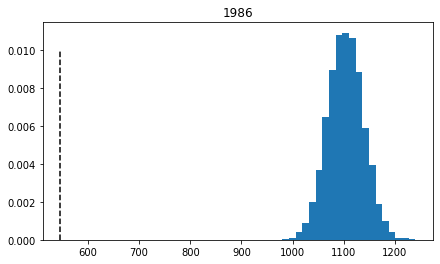

In [180]:
y_sim=params['y_sim']
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_1986,bins=20,density=True)
ax.set_title('1986')
tv = 546
ax.plot([tv,tv],[0,0.01],linestyle='--',color='black')

plt.show()

As we can see prediction for passengers deaths regarding flown miles is not as accurate as the previous one, when deaths rate wasnt depending on anything. Predicted number of passengers deaths is about 2 times bigger than the historical one. 